# Application to the XDF

## Data for this notebook 

We will be manipulating Hubble eXtreme Deep Field (XDF) data, which was collected using the Advanced Camera for Surveys (ACS) on Hubble between 2002 and 2012. The image we use here is the result of 1.8 million seconds (500 hours!) of exposure time, and includes some of the faintest and most distant galaxies that had ever been observed. 

*The methods demonstrated here are also available in the [`photutils.detection` documentation](http://photutils.readthedocs.io/en/stable/detection.html).*

*The original authors of this notebook were Lauren Chambers, Erik Tollerud and Tom Wilson.*


In [1]:
import warnings

from astropy.convolution import convolve
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

import numpy as np

from photutils.aperture import EllipticalAperture
from photutils.background import Background2D, MeanBackground
from photutils.centroids import centroid_2dg
from photutils.detection import find_peaks, DAOStarFinder, IRAFStarFinder
from photutils.segmentation import detect_sources, make_2dgaussian_kernel, SourceCatalog
from photutils.utils import make_random_cmap

# Show plots in the notebook
%matplotlib inline

In [2]:
xdf_image = CCDData.read('hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci.fits')
# Define the mask
mask = xdf_image.data == 0
xdf_image.mask = mask

In [3]:
mean, median, std = sigma_clipped_stats(xdf_image.data, sigma=3.0, maxiters=5, mask=xdf_image.mask)

In [4]:
plt.style.use('../photutils_notebook_style.mplstyle')

Beyond traditional source detection methods, an additional option for identifying sources in image data is a process called **image segmentation**. This method identifies and labels contiguous (connected) objects within an image. 

You might have noticed that, in the previous source detection algorithms, large and extended sources are often incorrectly identified as more than one source. Segmentation would label all the pixels within a large galaxy as belonging to the same object, and would allow the user to then measure the photometry, centroid, and morphology of the entire object at once.

## Creating a `SegmentationImage`

In [`photutils`](https://photutils.readthedocs.io/en/stable/), image segmentation maps are created using the threshold method in the [`detect_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) function. This method identifies all of the objects in the data that have signals above a determined **`threshold`** (usually defined as a multiple of the standard deviation) and that have more than a defined number of adjoining pixels, **`npixels`**. The data can also optionally be smoothed using a kernel, **`filter_kernel`**, before applying the threshold cut.

The [`detect_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) function returns a [`SegmentationImage`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage) object: an array in which each object is labeled with an integer. As a simple example, a segmentation map containing two distinct sources might look like this:

```
0 0 0 0 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 2 0
1 1 1 1 0 0 0 2 2 2
1 1 1 0 0 0 2 2 2 2
1 1 1 1 0 0 0 2 2 0
1 1 0 0 0 0 2 2 0 0
0 1 0 0 0 0 2 0 0 0
0 0 0 0 0 0 0 0 0 0
```
where all of the pixels labeled `1` belong to the first source, all those labeled `2` belong to the second, and all null pixels are designated to be background.

Let's see make the segmentation image for the XDF see what that segmentation map looks like.

In [5]:
# Define threshold and minimum object size
threshold = 5. * std
npixels = 10
fwhm = 5
kernel_size = 5
kernel = make_2dgaussian_kernel(fwhm, size=kernel_size)
convolved_data = convolve(xdf_image.data, kernel)
# Create a segmentation image
segm = detect_sources(convolved_data, threshold, npixels)

print('Found {} sources'.format(segm.max_label))

Found 1325 sources


The number of sources found with this method is similar to that found with the other methods we have considered. A more detailed comparison is made later in this section.

Text(0.5, 1.0, 'Segmentation Map')

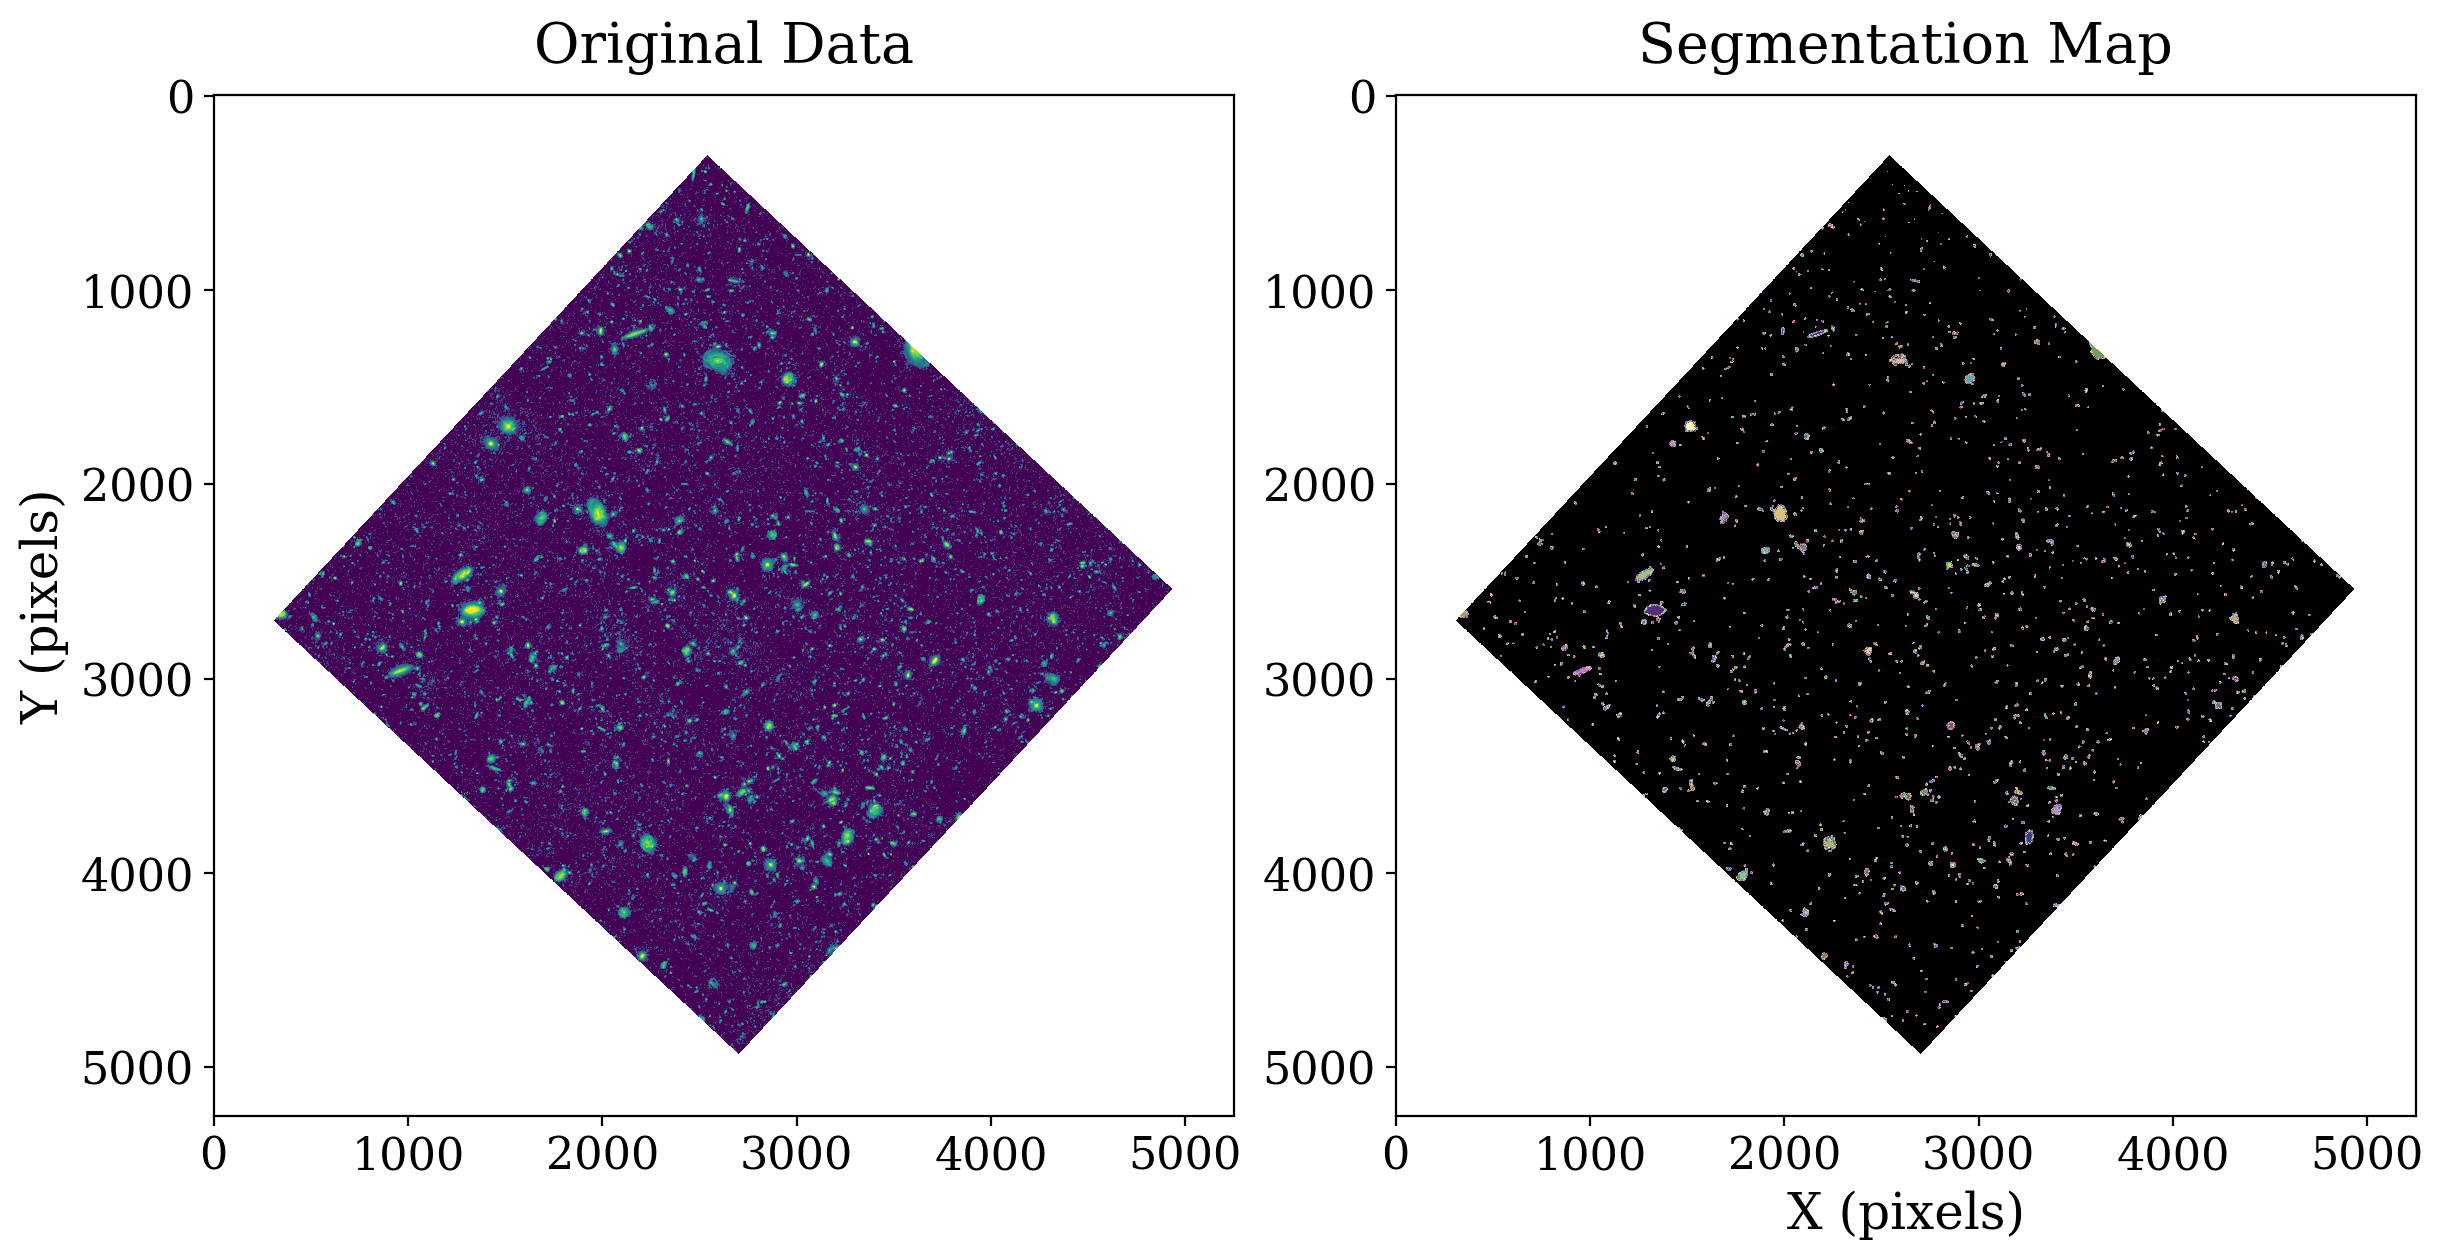

In [6]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout()

# Plot the data
# Set up the normalization and colormap
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch(), clip=False)
cmap = plt.get_cmap('viridis')
cmap.set_bad('white') # Show masked data as white

# Plot the original data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image),
                      norm=norm_image, cmap=cmap)
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Original Data')

# Plot the segmentation image
segplot = ax2.imshow(np.ma.masked_where(xdf_image.mask, segm), vmin=1, cmap=segm.cmap)
ax2.set_xlabel('X (pixels)')
ax2.set_title('Segmentation Map')

# # Define the colorbar
# cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
# cbar = plt.colorbar(segplot, cbar_ax)
# cbar.set_label('Object Label', rotation=270, labelpad=30)

Compare the sources in original data to those in the segmentation image. Each color in the segmentation map denotes a separate source.

You can easily see that larger galaxies are shown in the segmentation map as contiguous objects of the same color - for example, the two yellow and pink galaxies near (1200, 2500). Each pixel containing light from the same galaxy has been labeled as belonging to the same object.

## Analyzing `source_properties`

Once we have a [`SegmentationImage`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage) object, [`photutils`](https://photutils.readthedocs.io/en/stable/) provides many powerful tools to manipulate and analyze the identified objects. 

Individual objects within the segmentation map can be altered using methods such as `relabel` to change the labels of objects, `remove_labels` to remove objects, or `deblend_sources` to separating overlapping sources that were incorrectly labeled as one source.

However, perhaps the most powerful aspect of the [`SegmentationImage`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage) is the ability to create a catalog using [`SourceCatalog`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html#photutils.segmentation.SourceCatalog) to measure the centroids, photometry, and morphology of the detected objects:

In [7]:
catalog = SourceCatalog(xdf_image.data, segm)
table = catalog.to_table()
print(table)
print(table.colnames)

label     xcentroid          ycentroid      ...      kron_flux      kron_fluxerr
                                            ...                                 
----- ------------------ ------------------ ... ------------------- ------------
    1 2465.7386366359437 400.20823876076145 ...   3.786962750366321          nan
    2 2509.6568703244993 389.49620068710044 ... 0.16299322050344217          nan
    3  2525.699589429596 393.73426523584817 ...   1.236078180507074          nan
    4  2552.324164878554  458.6506964037056 ...  0.5374033079143501          nan
    5  2613.722439123769 463.56403761707145 ... 0.23589840050346006          nan
    6 2634.6926896288364 492.74771005940875 ... 0.40482659655037206          nan
    7 2678.0402364491715 496.13420772248094 ...  0.2312751888826329          nan
    8 2585.5976310775773 507.32125399722963 ...  0.3348800151373088          nan
    9 2325.5275032287905  553.6827394979126 ... 0.17353760980104416          nan
  ...                ...    

### Creating apertures from segmentation data

We can use this information to create isophotal ellipses for each identified source. These ellipses can also later be used as photometric apertures.

In [8]:
# Define the approximate isophotal extent
r = 4.  # pixels

# Create the apertures
apertures = []
for obj in catalog:
    position = (obj.xcentroid, obj.ycentroid)
    a = obj.semimajor_sigma.value * r
    b = obj.semiminor_sigma.value * r
    theta = obj.orientation
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

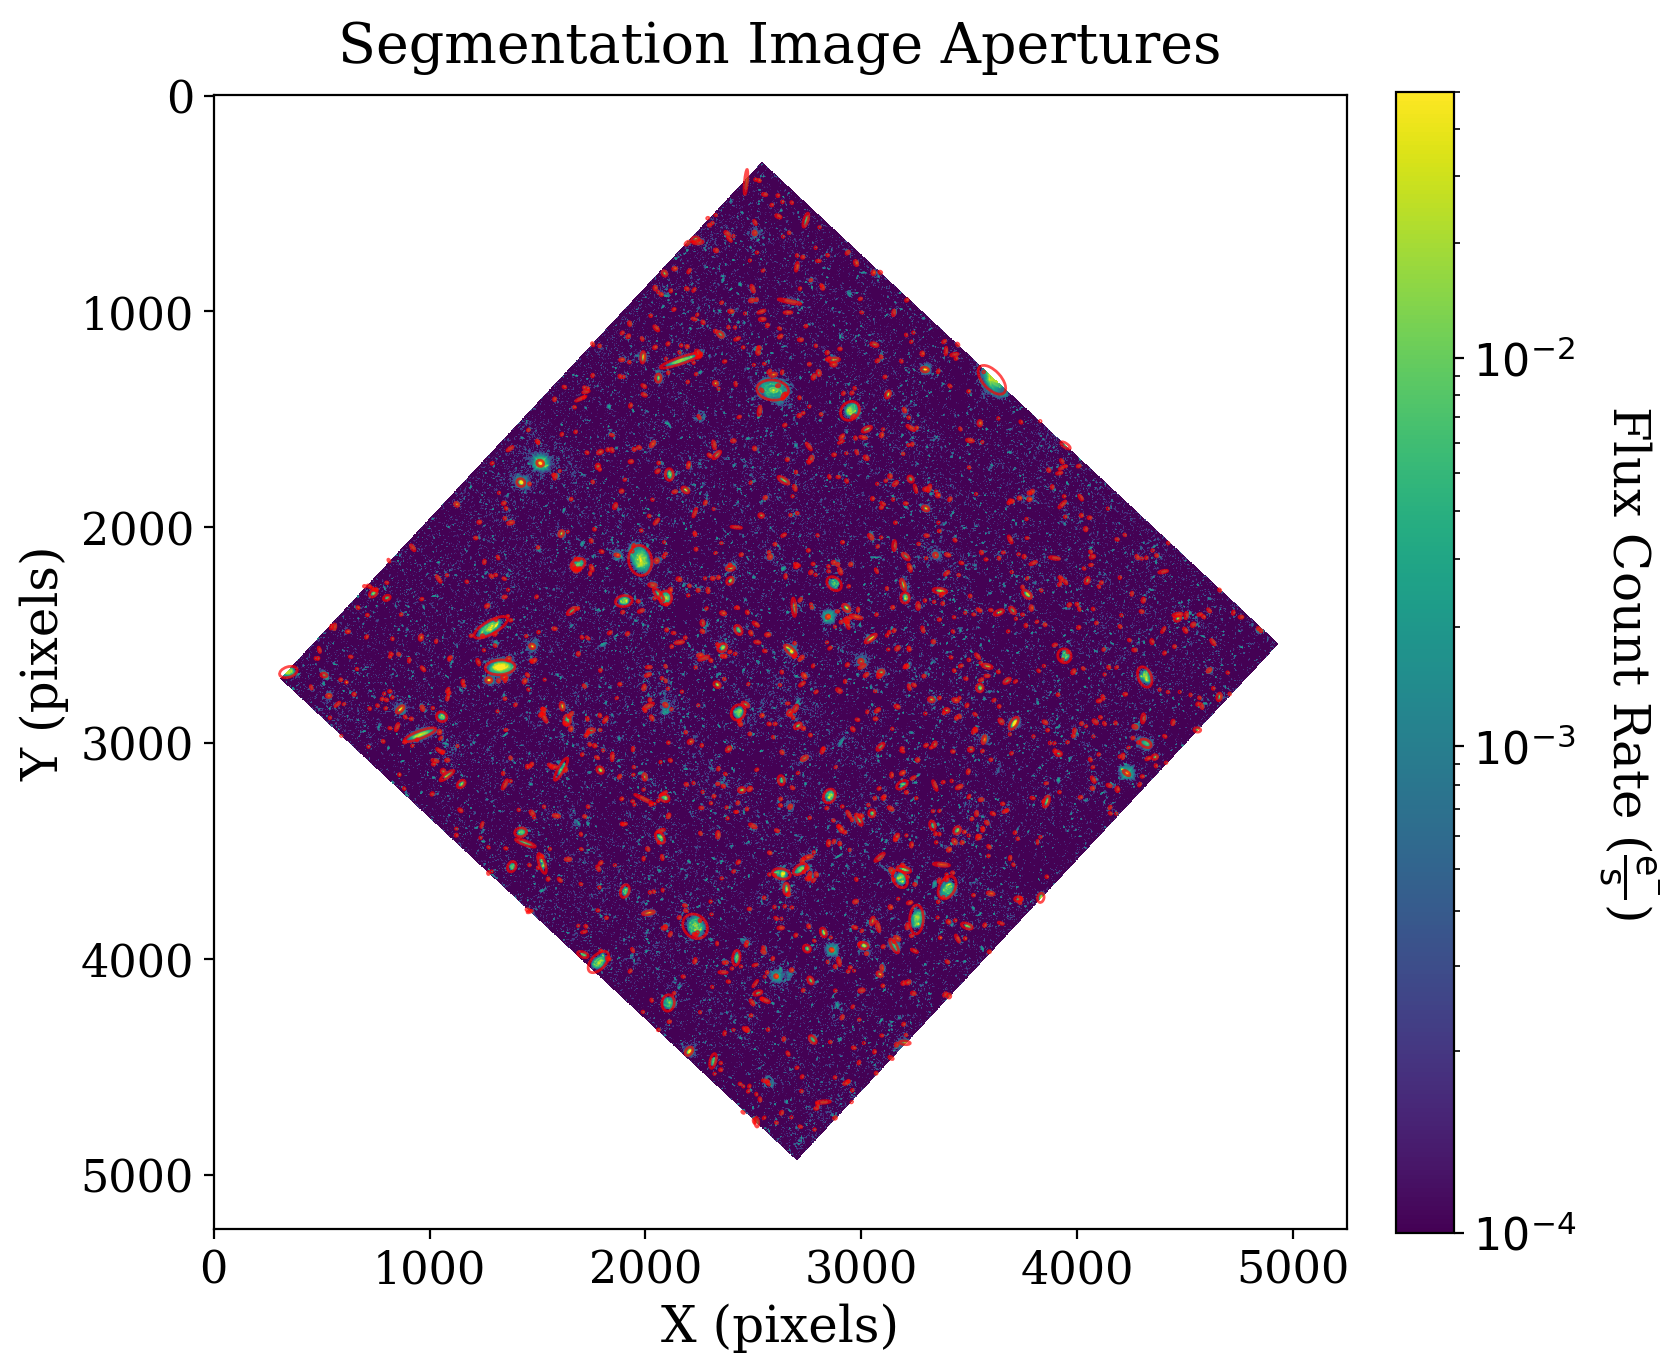

In [9]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image),
                      norm=norm_image, cmap=cmap)

# Plot the apertures
for aperture in apertures:
    aperture.plot(color='red', lw=1, alpha=0.7, axes=ax1)

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator())

def format_colorbar(bar):
    # Add minor tickmarks
    bar.ax.yaxis.set_minor_locator(LogLocator(subs=range(1, 10)))

    # Force the labels to be displayed as powers of ten and only at exact powers of ten
    bar.ax.set_yticks([1e-4, 1e-3, 1e-2])
    labels = [f'$10^{{{pow:.0f}}}$' for pow in np.log10(bar.ax.get_yticks())]
    bar.ax.set_yticklabels(labels)

format_colorbar(cbar)

# Define labels
cbar.set_label(r'Flux Count Rate ({})'.format(xdf_image.unit.to_string('latex')),
               rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Segmentation Image Apertures');

## Comparison with other detection methods

We begin by finding sources using [`DAOStarFinder`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder) and [`find_peaks`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks).

In [10]:
with warnings.catch_warnings(action="ignore"):
    sources_findpeaks = find_peaks(xdf_image.data - median, mask=xdf_image.mask,
                                   threshold=20. * std, box_size=29,
                                   centroid_func=centroid_2dg)

# Add an ID column to the find_peaks result
sources_findpeaks["source_id"] = np.arange(len(sources_findpeaks))

In [11]:
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
sources_dao = daofind(np.ma.masked_where(xdf_image.mask, xdf_image))

A plot of a random subset of sources highlights the differences between the methods.

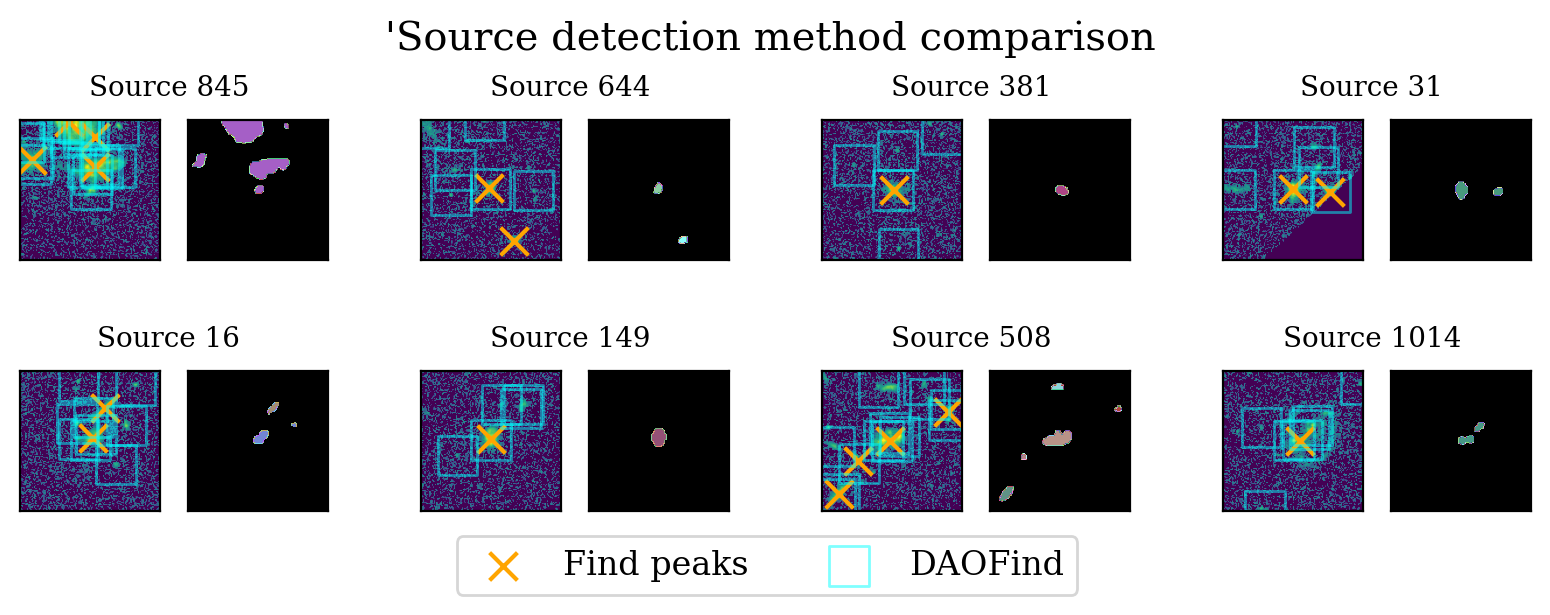

In [12]:
fig = plt.figure(figsize=(8, 2.5))
sub_figs = fig.subfigures(nrows=2, ncols=4, wspace=0.01, hspace=0.01)

cutout_size = 60
rng = np.random.default_rng(seed=8675309)
srcs = rng.permutation(sources_findpeaks)[:len(sub_figs.flatten())]
for a_fig, src in zip(sub_figs.flatten(), srcs):
    sub_axs = a_fig.subplot_mosaic([["orig", "segm"]], sharex=True, sharey=True, )
    left = int(src['x_peak'] - cutout_size)
    bottom = int(src['y_peak'] - cutout_size)
    right = left + 2 * cutout_size
    top = bottom + 2 * cutout_size
    slc = (slice(bottom, top), slice(left, right))
    sources_in_cutout_fp = ((left < sources_findpeaks["x_centroid"]) & (sources_findpeaks["x_centroid"] < right) &
                             (bottom < sources_findpeaks["y_centroid"]) & (sources_findpeaks["y_centroid"] < top))
    sources_in_cutout_dao = ((left < sources_dao["xcentroid"]) & (sources_dao["xcentroid"] < right) &
                             (bottom < sources_dao["ycentroid"]) & (sources_dao["ycentroid"] < top))
    sub_axs["orig"].imshow(xdf_image.data[slc], cmap=cmap, norm=norm_image, origin="lower")
    sub_axs["orig"].scatter(sources_findpeaks["x_centroid"][sources_in_cutout_fp] - left, 
                            sources_findpeaks["y_centroid"][sources_in_cutout_fp] - bottom, 
                            marker="x", color="orange", s=100, label="Find peaks")
    sub_axs["orig"].scatter(sources_dao["xcentroid"][sources_in_cutout_dao] - left, 
                            sources_dao["ycentroid"][sources_in_cutout_dao] - bottom, 
                            marker="s", facecolor="none", edgecolor="cyan", s=200, 
                            alpha=0.5, label="DAOFind")

    rand_cmap = make_random_cmap()
    rand_cmap.set_under('black')
    sub_axs["segm"].imshow(segm.data[slc], cmap=rand_cmap, vmin=1, vmax=len(sources_findpeaks), origin="lower")
    src_id = src["source_id"]
    # ax.text(2, 2, str(src_id), color='w', va='top')
    a_fig.suptitle(f"Source {src_id}", fontsize=10)

    for ax in sub_axs.values():
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle("'Source detection method comparison", y=1.1)
a_fig.legend(ncols=2, bbox_to_anchor=(-.2, 0.2));

Star finding finds almost all of the point-like sources in these cutouts, but also identifies many sources in each extended object. Peak finding misses many of the star-like objects and sometimes assigns multiple objects to a single extended source. Image segmentation identifies extended sources as single objects but misses most of the small star-like objects. Adjusting the image segmentation parameters to allow smaller sources would improve detection of those objects.

We now look at the large galaxy near the top center of the XDF. Image segmentation is the only method that correctly identifies that large galaxy as a single object.

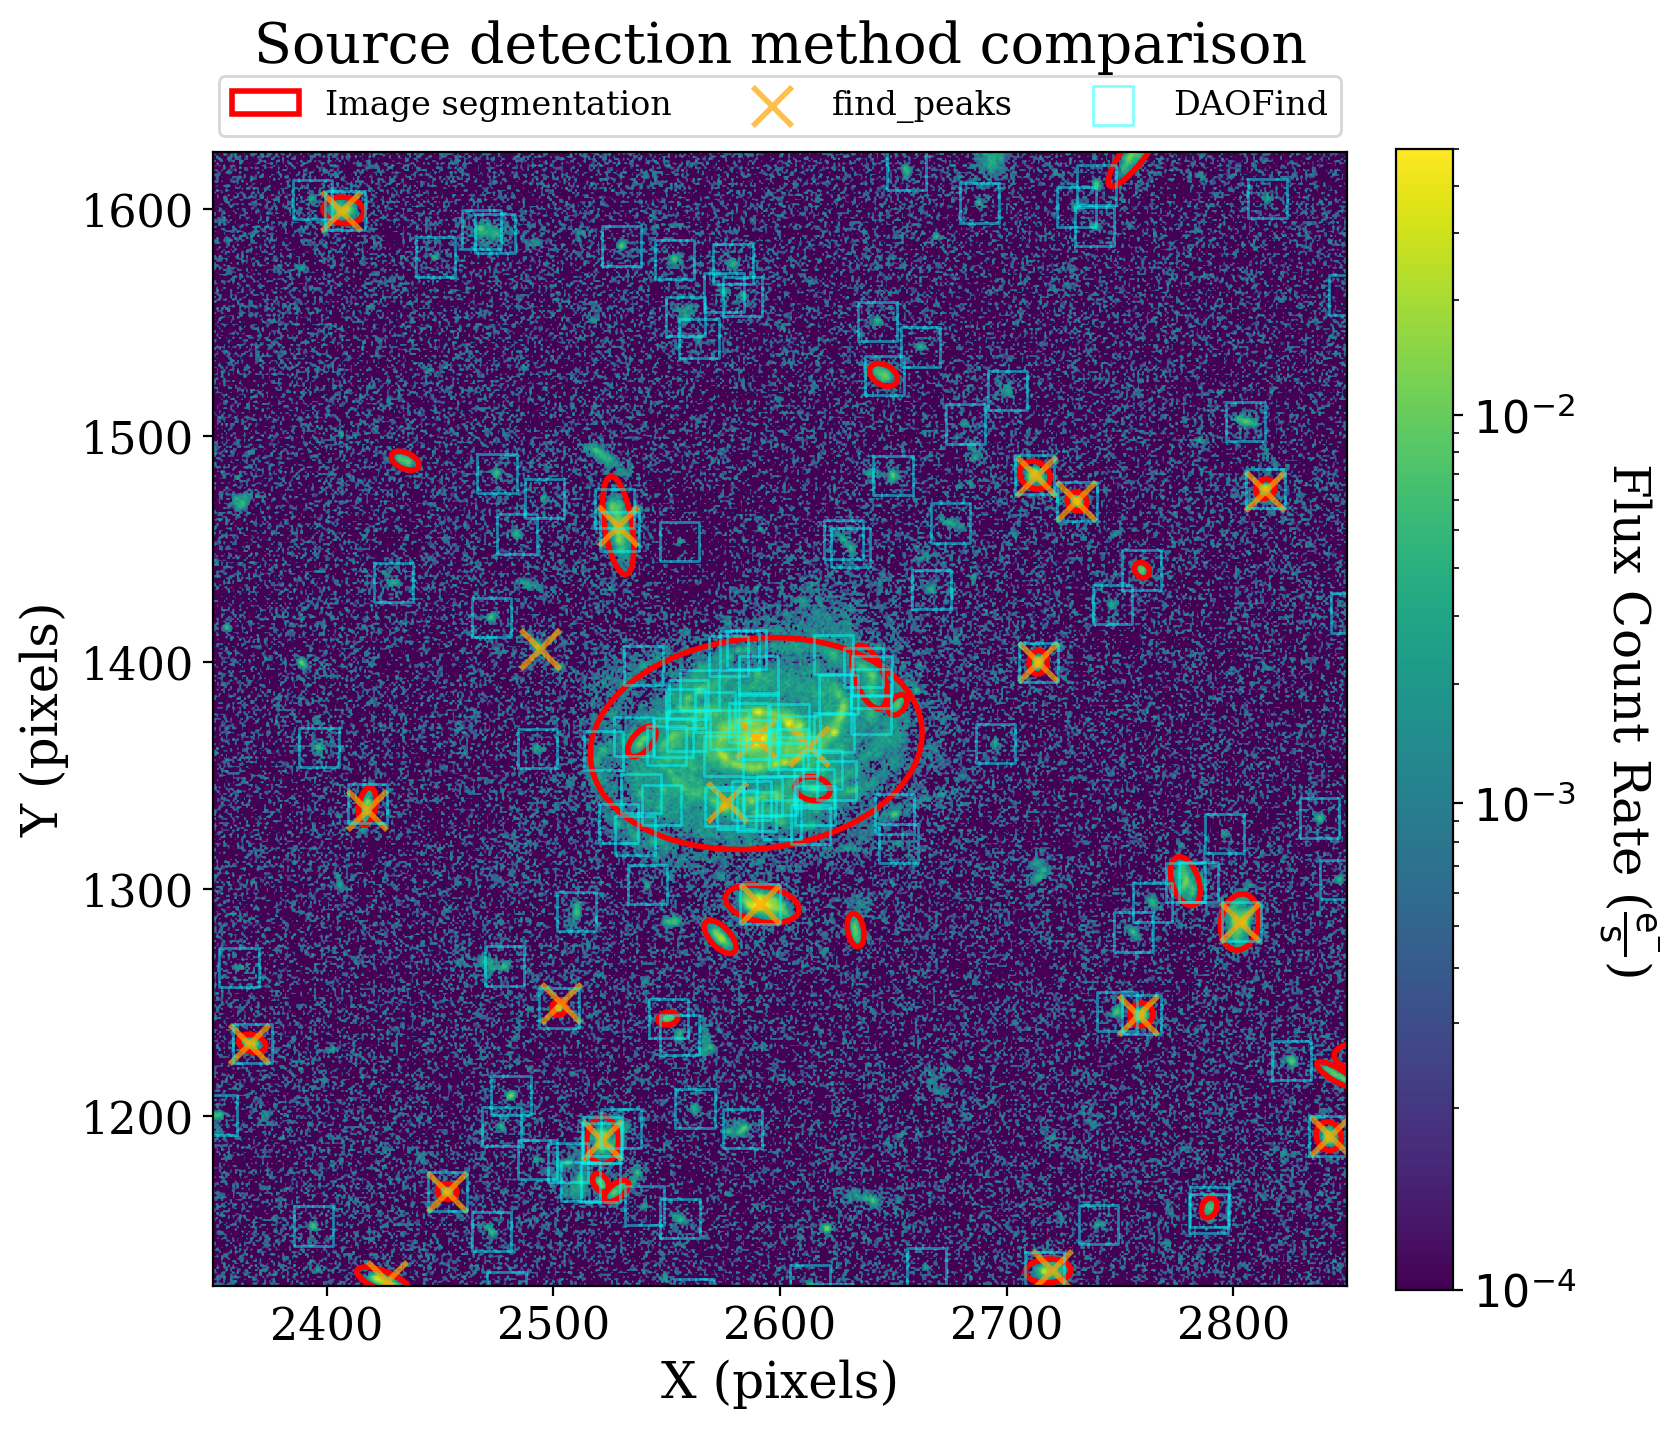

In [13]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image),
                      norm=norm_image, cmap=cmap)

# Plot the apertures
apertures[0].plot(color='red', lw=2, alpha=1, axes=ax1, label="Image segmentation")
for aperture in apertures[1:]:
    aperture.plot(color='red', lw=2, alpha=1, axes=ax1)

# Add find_peaks sources
ax1.scatter(sources_findpeaks["x_centroid"], sources_findpeaks["y_centroid"], 
            marker="x", color="orange", s=200, lw=2, alpha=0.7, label="find_peaks")

# Add DAOStarFinder sources
ax1.scatter(sources_dao["xcentroid"], sources_dao["ycentroid"], 
            marker="s", facecolor="none", edgecolor="cyan", s=200, alpha=0.5, label="DAOFind")

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator())

format_colorbar(cbar)

# Define labels
cbar.set_label(r'Flux Count Rate ({})'.format(xdf_image.unit.to_string('latex')),
               rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

top = 1125
left = 2350
cutout_size = 500

ax1.set_xlim(left, left + cutout_size)
ax1.set_ylim(top, top + cutout_size)

ax1.legend(ncols=3, loc='lower center', bbox_to_anchor=(0.5, 1))

ax1.set_title('Source detection method comparison', y=1.05);

## Summary

The image above nicely captures the differences between the source detection methods we have discussed. [`DAOStarFinder`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder) does an excellent job detecting the star-like sources in the image but not the more extended sources. [`find_peaks`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks) detects both extended and point-like sources, but misses several sources. Image segmentation does an excellent job detecting sources, and could detect the smaller sources in this image if we reduced the minimum number of pixels in each source.